<a href="https://colab.research.google.com/github/alfaroqueIslam/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [x] Make exploratory visualizations.
- [x] Do one-hot encoding.
- [x] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [x] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [0]:
df

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,Other,8/27/2019,NaN,NaN,NaN,6.00,1.0,NaN,NaN,17.0,20.5,0.57,5.0,4.0,3.5,NaN,4.0,4.0,2.0,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
419,Other,8/27/2019,NaN,NaN,NaN,6.00,4.0,NaN,NaN,19.0,26.0,1.02,4.0,5.0,NaN,3.5,4.0,4.0,5.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
420,California,8/27/2019,NaN,NaN,NaN,7.90,3.0,NaN,NaN,20.0,22.0,0.77,4.0,4.0,4.0,3.7,3.0,2.0,3.5,4.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
421,Other,8/27/2019,NaN,NaN,NaN,7.90,3.0,NaN,NaN,22.5,24.5,1.07,5.0,2.0,5.0,5.0,5.0,2.0,5.0,5.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [0]:

train = df[df['Date'].str.contains("2016")]
val = df[df['Date'].str.contains("2017")]
test = df[df.Date.str[-4:] == '2018']
print(train)
print(validate)
print(test)

        Burrito        Date  Yelp  Google  ... Avocado  Corn  Zucchini  Great
0    California   1/18/2016   3.5     4.2  ...     NaN   NaN       NaN  False
1    California   1/24/2016   3.5     3.3  ...     NaN   NaN       NaN  False
2      Carnitas   1/24/2016   NaN     NaN  ...     NaN   NaN       NaN  False
3         Asada   1/24/2016   NaN     NaN  ...     NaN   NaN       NaN  False
4    California   1/27/2016   4.0     3.8  ...     NaN   NaN       NaN   True
..          ...         ...   ...     ...  ...     ...   ...       ...    ...
296  California   12/2/2016   4.0     4.3  ...     NaN   NaN       NaN  False
297       Other   12/2/2016   NaN     NaN  ...     NaN   NaN       NaN  False
298  California  12/10/2016   3.5     3.7  ...     NaN   NaN       NaN  False
299       Asada  12/10/2016   NaN     NaN  ...     NaN   NaN       NaN  False
300       Other  12/15/2016   4.5     4.6  ...     NaN   NaN       NaN  False

[296 rows x 59 columns]
        Burrito        Date  Yelp  Goog

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

In [0]:
from sklearn.metrics import accuracy_score

In [0]:
features = ['Tortilla',	'Temp',	'Meat',	'Fillings',	'Meat:filling',	'Uniformity',	'Salsa',	'Synergy',	'Wrap']
target = 'Great'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[features]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((296, 9), (296,), (85, 9), (85,), (27, 9), (27, 9))

In [0]:
y_train.value_counts(normalize=True)

False    0.591216
True     0.408784
Name: Great, dtype: float64

In [0]:
y_train.mode()

0    False
dtype: bool

In [0]:
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)
y_pred[:5]

[False, False, False, False, False]

In [0]:
accuracy_score(y_train, y_pred)

0.5912162162162162

In [0]:
# Calculate for our validation as well
y_val = val[target]
y_pred = [majority_class] * len(y_val)
accuracy_score(y_val, y_pred)

0.5529411764705883

In [0]:
X_train.head()

,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap
0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0
1,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0
2,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0
3,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0
4,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0


In [0]:
X_val.head()

,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap
301,4.0,4.5,4.0,3.5,3.5,5.0,1.5,3.50,4.5
302,4.0,2.0,NaN,4.0,NaN,4.6,4.2,3.75,5.0
303,3.0,4.5,4.1,3.0,3.7,4.0,4.3,4.20,5.0
304,3.5,4.0,4.0,3.0,4.0,4.5,4.0,3.80,4.8
305,2.5,4.5,3.0,2.5,3.0,3.0,2.0,2.00,4.0


In [0]:
X_train.isnull().sum()

Tortilla         0
Temp            13
Meat            10
Fillings         1
Meat:filling     6
Uniformity       2
Salsa           20
Synergy          2
Wrap             2
dtype: int64

In [0]:
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)

In [0]:
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

In [0]:
X_train_encoded.head()

,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap
0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0
1,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0
2,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0
3,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0
4,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0


In [0]:
X_train_encoded.describe()

,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap
count,296.000000,283.000000,286.000000,295.000000,290.000000,294.000000,276.000000,294.000000,294.000000
mean,3.468750,3.706360,3.551573,3.515763,3.529069,3.395238,3.323370,3.537075,3.958163
std,0.794864,0.991897,0.863422,0.848306,1.036565,1.091940,0.966205,0.921086,1.164133
min,1.400000,1.000000,1.000000,1.000000,0.500000,1.000000,0.000000,1.000000,0.000000
25%,3.000000,3.000000,3.000000,3.000000,3.000000,2.500000,2.500000,3.000000,3.500000
50%,3.500000,4.000000,3.500000,3.500000,4.000000,3.500000,3.500000,3.750000,4.000000
75%,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [0]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)
X_test_imputed = imputer.transform(X_test_encoded)

In [0]:
X_val_imputed[:5]

array([[4.        , 4.5       , 4.        , 3.5       , 3.5       ,
        5.        , 1.5       , 3.5       , 4.5       ],
       [4.        , 2.        , 3.55157343, 4.        , 3.52906897,
        4.6       , 4.2       , 3.75      , 5.        ],
       [3.        , 4.5       , 4.1       , 3.        , 3.7       ,
        4.        , 4.3       , 4.2       , 5.        ],
       [3.5       , 4.        , 4.        , 3.        , 4.        ,
        4.5       , 4.        , 3.8       , 4.8       ],
       [2.5       , 4.5       , 3.        , 2.5       , 3.        ,
        3.        , 2.        , 2.        , 4.        ]])

In [0]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [0]:
X_val_scaled[:5]

array([[ 6.69485446e-01,  8.19743424e-01,  5.29287535e-01,
        -1.86444925e-02, -2.83811540e-02,  1.47714802e+00,
        -1.95787509e+00, -4.04567655e-02,  4.67818945e-01],
       [ 6.69485446e-01, -1.76248486e+00, -5.24168051e-16,
         5.72766830e-01,  0.00000000e+00,  1.10895682e+00,
         9.41297325e-01,  2.32348030e-01,  8.99516277e-01],
       [-5.90722452e-01,  8.19743424e-01,  6.47319687e-01,
        -6.10055815e-01,  1.66886572e-01,  5.56670024e-01,
         1.04867408e+00,  7.23396661e-01,  8.99516277e-01],
       [ 3.93814968e-02,  3.03297767e-01,  5.29287535e-01,
        -6.10055815e-01,  4.59788161e-01,  1.01690902e+00,
         7.26543813e-01,  2.86908989e-01,  7.26837344e-01],
       [-1.22082640e+00,  8.19743424e-01, -6.51033985e-01,
        -1.20146714e+00, -5.16550469e-01, -3.63807969e-01,
        -1.42099131e+00, -1.67728554e+00,  3.61216135e-02]])

In [0]:
model = LogisticRegressionCV()
model.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [0]:
y_pred = model.predict(X_val_scaled)
accuracy_score(y_val, y_pred)

0.8823529411764706

In [0]:
model.score(X_val_scaled, y_val)

0.8823529411764706

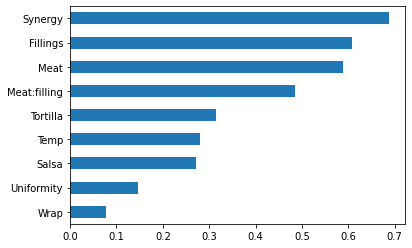

In [0]:
%matplotlib inline
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients.sort_values().plot.barh();